In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os


In [18]:
def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    return np.expand_dims(img_array, axis=0), img

In [19]:
def compute_gradcam(model, img_array, layer_name='block5_conv3', use_softmax=False):
    conv_layer = model.get_layer(layer_name).output
    softmax_output = model.output
    if not use_softmax:
        logits_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        with tf.GradientTape() as tape:
            conv_model = tf.keras.Model(model.input, [conv_layer, logits_model.output])
            conv_outputs, logits = conv_model(img_array)
            class_idx = tf.argmax(logits[0])
            loss = logits[:, class_idx]
    else:
        with tf.GradientTape() as tape:
            conv_model = tf.keras.Model(model.input, [conv_layer, softmax_output])
            conv_outputs, preds = conv_model(img_array)
            class_idx = tf.argmax(preds[0])
            loss = preds[:, class_idx]
    tape.watch(conv_outputs)
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-10
    return heatmap

In [20]:
def overlay_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    output = heatmap_color * alpha + original_img
    return np.uint8(output)


In [21]:

def integrated_gradients(model, img_input, baseline=None, steps=50, use_pre_softmax=False):
    img_input = tf.cast(img_input, tf.float32)
    if baseline is None:
        baseline = tf.zeros(shape=img_input.shape)
    interpolated = [(baseline + (float(i) / steps) * (img_input - baseline)) for i in range(steps + 1)]
    interpolated = tf.concat(interpolated, axis=0)
    if use_pre_softmax:
        logits_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            preds = logits_model(interpolated)
            class_idx = tf.argmax(logits_model(img_input)[0])
            probs = preds[:, class_idx]
    else:
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            preds = model(interpolated)
            class_idx = tf.argmax(model(img_input)[0])
            probs = preds[:, class_idx]

    grads = tape.gradient(probs, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads.numpy()[0]

In [22]:
def generate_adversarial_image(model, img_array, epsilon=0.01):
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        class_idx = tf.argmax(prediction[0])
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            tf.convert_to_tensor([class_idx], dtype=tf.int64), prediction
        )
    gradient = tape.gradient(loss, img_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_img = img_tensor + epsilon * signed_grad
    adversarial_img = tf.clip_by_value(adversarial_img, 0, 255)
    return adversarial_img.numpy()

In [39]:
def show_images(images, titles, save=False, save_dir='outputs'):
    # --- Prep images into H×W×C uint8 arrays -------------------------
    proc_imgs = []
    for img in images:
        # if tensor, convert to numpy
        if hasattr(img, 'numpy'):
            img = img.numpy()
        # Squeeze batch dimension if present
        if isinstance(img, np.ndarray) and img.ndim == 4 and img.shape[0] == 1:
            img = img[0]
        # If PIL, convert to numpy
        if not isinstance(img, np.ndarray):
            try:
                img = np.array(img)
            except:
                raise ValueError(f"Cannot convert {type(img)} to numpy array")

        # Now img is np.ndarray
        # Normalize floats to [0,1] and convert to uint8
        if np.issubdtype(img.dtype, np.floating):
            mn, mx = img.min(), img.max()
            if mn < 0 or mx > 1:
                # assume [−1,1]
                img = (img + 1) * 0.5
            # now scale [0,1]→[0,255]
            img = (img - img.min()) / (img.max() - img.min())
            img = (img * 255).astype(np.uint8)
        elif img.dtype != np.uint8:
            # e.g. int16, float64: just clip and cast
            img = np.clip(img, 0, 255).astype(np.uint8)

        proc_imgs.append(img)

    # --- Display ------------------------------------------------------
    n = len(proc_imgs)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, proc_imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Save if requested -------------------------------------------
    if save:
        os.makedirs(save_dir, exist_ok=True)
        for img, title in zip(proc_imgs, titles):
            fn = f"{title.replace(' ', '_').lower()}.png"
            path = os.path.join(save_dir, fn)
            plt.imsave(path, img)
        print(f"Saved images to: {save_dir}/")

In [40]:
def plot_ig_attribution(attribution, original_img):
    attr = np.sum(np.abs(attribution), axis=-1)
    attr = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-10)
    attr = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_JET)
    overlay = 0.4 * attr + original_img
    return np.uint8(overlay)

In [41]:

model = VGG16(weights='imagenet')
img_array, raw_img = load_image('/content/sample_data/1.png')
prep_img = preprocess_input(img_array)

In [42]:
adv_img = generate_adversarial_image(model, prep_img, epsilon=0.02)


In [43]:
gradcam_orig = compute_gradcam(model, prep_img, 'block5_conv3', use_softmax=False)
gradcam_adv = compute_gradcam(model, adv_img, 'block5_conv3', use_softmax=False)

In [44]:
gradcam_orig_soft = compute_gradcam(model, prep_img, 'block5_conv3', use_softmax=True)
gradcam_adv_soft = compute_gradcam(model, adv_img, 'block5_conv3', use_softmax=True)

In [45]:
orig_overlay = overlay_heatmap(gradcam_orig, np.array(raw_img.copy()))
adv_overlay = overlay_heatmap(gradcam_adv, np.array(raw_img.copy()))
orig_soft_overlay = overlay_heatmap(gradcam_orig_soft, np.array(raw_img.copy()))
adv_soft_overlay = overlay_heatmap(gradcam_adv_soft, np.array(raw_img.copy()))

In [46]:
ig_orig = integrated_gradients(model, prep_img, use_pre_softmax=True)
ig_adv = integrated_gradients(model, adv_img, use_pre_softmax=True)

In [47]:


ig_orig_img = plot_ig_attribution(ig_orig, raw_img.copy())
ig_adv_img = plot_ig_attribution(ig_adv, raw_img.copy())


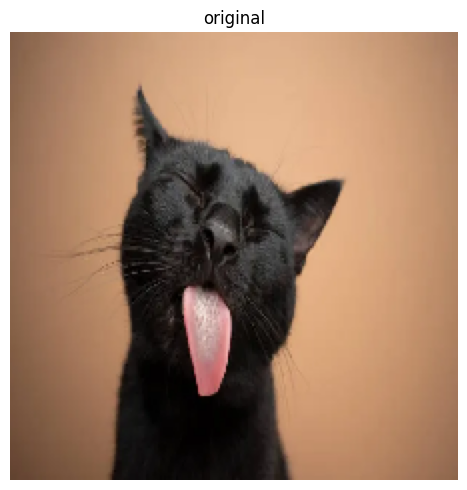

In [48]:
show_images([raw_img], ['original'])

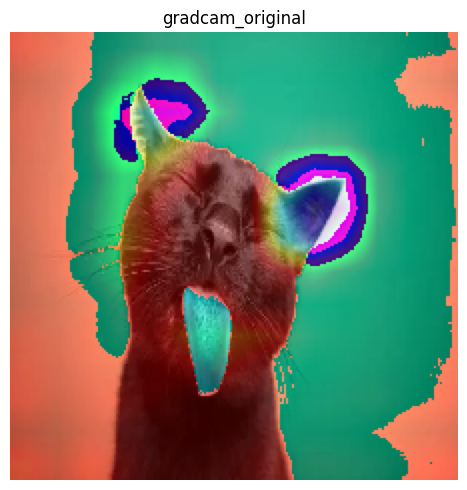

In [49]:
show_images([orig_overlay], ['gradcam_original'])

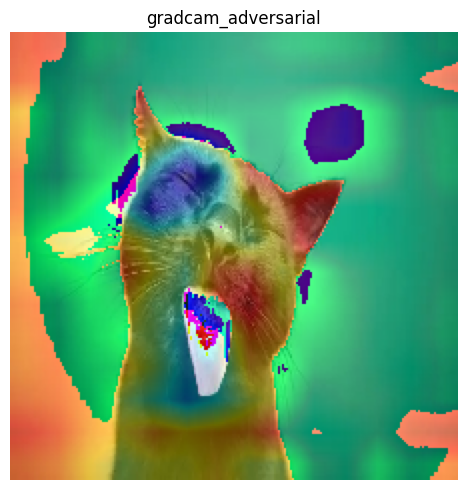

In [50]:

show_images([adv_overlay], ['gradcam_adversarial'])

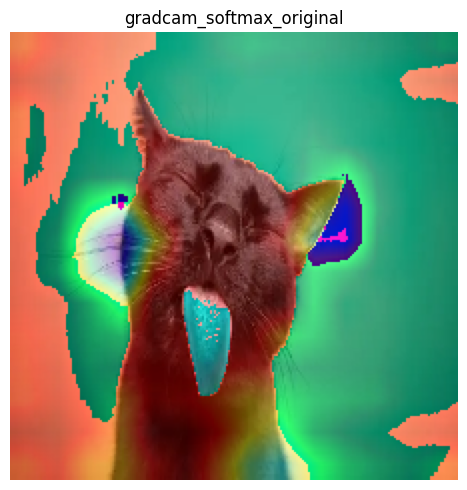

In [51]:
show_images([orig_soft_overlay], ['gradcam_softmax_original'])

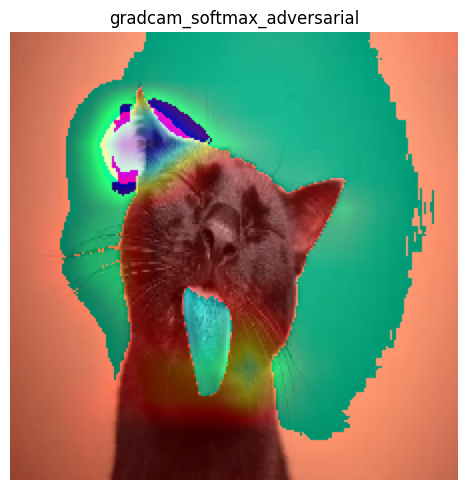

In [52]:
show_images([adv_soft_overlay], ['gradcam_softmax_adversarial'])

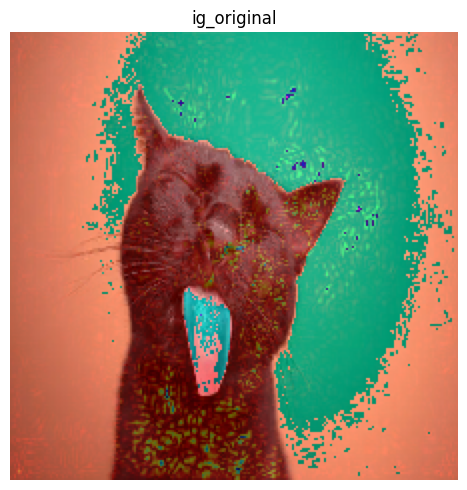

In [53]:

show_images([ig_orig_img], ['ig_original'])

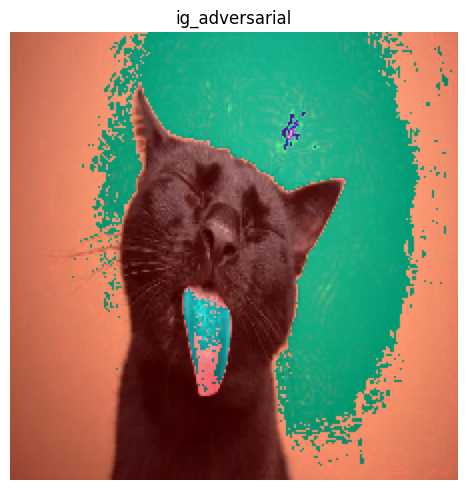

In [54]:
show_images([ig_adv_img], ['ig_adversarial'])